## 6. Choosing the number of component to conside

### Load the data

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_olivetti_faces


def load_olivetti():
    """
    Load the Olivetti dataset.
    :return: tuple of data and labels.
    """

    olivetti = fetch_olivetti_faces()

    return olivetti.data, olivetti.images

In [2]:
faces_data, faces_images = load_olivetti()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [3]:
def show_some_images(imgs):
    """
    Show some images of the given set of images.
    :param imgs: 2D-array.
        An array of images.
    :return: Matplotlib figure
    """

    fig = plt.figure(figsize=(20, 5))

    for i in range(14):
        ax = fig.add_subplot(2, 7, i+1)
        ax.imshow(imgs[i], cmap='gray')

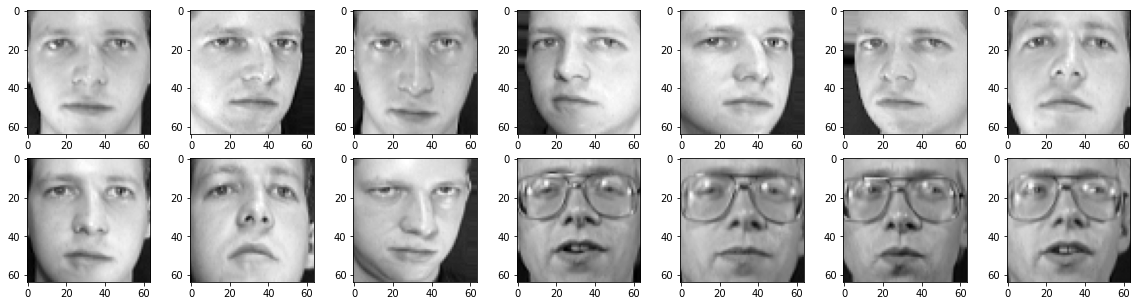

In [4]:
show_some_images(faces_images)

In [5]:
def calculate_gamma_of_array(arr):
    """
    Calculate the sum over columns in a 2D-array.
    :param arr: array_like
        An array to be transposed.
    :return: An_array
        1D-array of the summed columns
    """

    sum_of_gammas = arr.sum(axis=0)
    return sum_of_gammas


def psi(face_image):
    """
    Calculates the mean image.
    :param face_image: array_like
    :return:
    """

    mean_array = calculate_gamma_of_array(face_image)
    num_images = face_image.shape[0]

    psi_val = mean_array * (1/num_images)

    return psi_val

In [6]:
# The mean face.
psi_val = psi(faces_data) # of shape (4096, )

In [7]:
psi_val = psi(faces_data) # of shape (4096, )

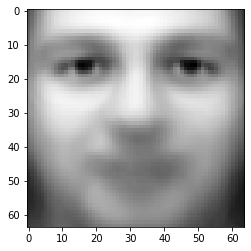

In [8]:
plt.imshow(psi_val.reshape(64, 64), cmap='gray')
plt.show()

## Substracting the mean image from the faces to extract the proper features

In [13]:
def calculate_phi(data):
    """
    Calculates the array of proper features of each image in the given array, with each column
    represents an image.
    :param data: array_like
        An array of images
    Calculate the mean feature of an image.
    phi = gamma(The original image) - psi(The mean image)
    :return: array_like
        An array of the main feature of each image.
    """

    # The proper features array of the images
    phi = np.zeros((400, 4096))

    # The mean image
    psi_value = psi(data)

    # Calculate the array of the proper feature of each image.
    for i in range(400):
        phi[i] = data[i] - psi_value

    return phi

In [15]:
phi = calculate_phi(faces_data) # of shape (400, 4096)

## Proper features of each image

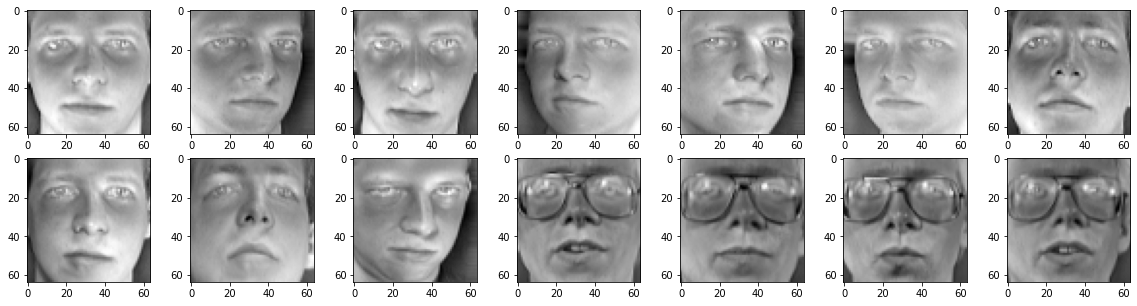

In [16]:
proper_imgs = phi.reshape(400, 64, 64)
show_some_images(proper_imgs)

In [17]:
phi.shape

(400, 4096)

In [18]:
from sklearn.decomposition import PCA

def pca_vs_variance(imgs, variance=0.95):
    """
    Plot the pca versus variance to choose accurately the number of components.
    :param variance: double
        The variance.
    :param imgs: array_like
        Array of images..
    :return The trained model.
    """

    # Fit the model
    pca = PCA().fit(imgs)
    y = np.cumsum(pca.explained_variance_ratio_)
    plt.axhline(y=variance, color='r', linestyle='-')
    plt.text(0.1, variance + 0.02, f'{variance * 100}% cut-off threshold', color='red', fontsize=10)
    plt.plot(y, linestyle='--', color='b')
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')

    return pca


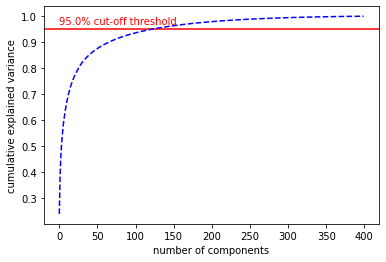

In [19]:
pca = pca_vs_variance(faces_data, variance=0.95)

As we can see, we got 0.95 explained variance for roughly 120 components.

## Show eigen faces

In [20]:
import matplotlib.pyplot as plt

def show_eigen_faces(imgs, n_components):
    """
    Show some images from the eigen faces.
    :return: None
    """

    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)
    pca.fit(imgs)
    fig = plt.figure(figsize=(20, 5))

    for i in range(min(n_components, 14)):
        ax = fig.add_subplot(2, 7, i + 1)
        ax.imshow(pca.components_[i].reshape(64, 64), cmap='gray')


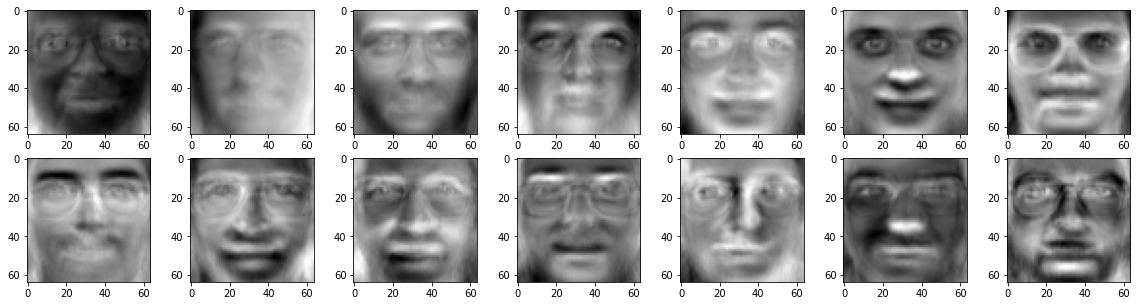

In [21]:
show_eigen_faces(faces_data, 120)

## Choose the number of component to consider

We will take the first 20 components to project our images 

In [65]:
def select_components(n_comps, pca):
    """
    Select the `n_comps` to retain for the projection.
    :param pca: the trained model
    :param n_comps:
    :return: array_like
        An array of the selected components
    """
    retained_comps = []
    for i in range(n_comps):
        retained_comps.append(pca.components_[i])

    return retained_comps

In [69]:
comps_retained = np.array(select_components(120, pca))

In [70]:
comps_retained.shape

(120, 4096)

## Select a face to make recognition

In [94]:
face_index = 20
face_vector = faces_data[20]
face = face_vector.reshape(64, 64)

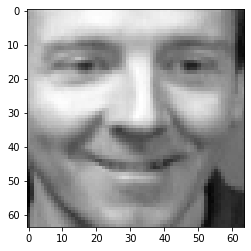

In [79]:
plt.imshow(face, cmap='gray')

In [103]:
def project_img(img, components):
    """
    Proejct the given image in the space formed by components.
    :param img: array_like
        An array like
    :param components: array_like
        An array of retained components
    :return: weights of the projection.
    """
    weights = np.zeros((len(components)))

    for comps in components:
        np.append(weights, np.dot(img, comps))

    return weights

import numpy as np

def project_imgs(imgs, components):
    """
    Take a set of images an returns the weights of each one.
    :param components: array_like
        An array of components.
    :param imgs: array_like
    :return: array_like
        Array of weights.
    """

    weights = np.zeros((len(imgs), len(components)))

    for img in imgs:
        np.append(weights, project_img(img, components))

    return weights


In [120]:
import numpy as np
import matplotlib.pyplot as plt


def recognize_face(img, imgs, components, n_faces=7):
    """
    Recognize the given face and return the recognized faces.
    :param n_faces: integer
        Number of images to return.
    :param components: array_like
        An array of components.
    :param img: array_like
        The face to recognized
    :param imgs: array_like
        The dataset of faces
    :return: array_like
        `n_faces` index of similar faces.
    """

    distance = np.empty(shape=[len(imgs)])
    weight_face = project_img(img, components)
    weights = project_imgs(imgs, components)

    for weight in weights:
        delta = weight - weight_face
        np.append(distance, sum(abs(delta)))

    # Show the similar faces
    fig = plt.figure(figsize=(20, 5))

    for i in range(n_faces):
        ax = fig.add_subplot(2, 7, i + 1)
        ax.imshow(imgs[i].reshape(64, 64), cmap='gray')

    # index of similar image with smallest difference.
    return distance.argsort()[:n_faces]


array([3, 4, 6, 5, 0, 7, 8])

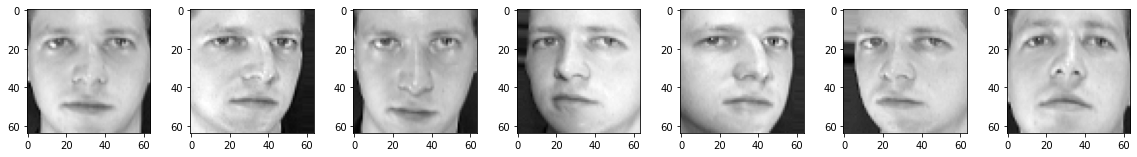

In [121]:
recognize_face(face_vector, faces_data, comps_retained)